# intro

The purpose of this notebook create volume distribution in TS for two example years, so we can begin to form an idea of what is changing over that time period

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# read grid and files

In [4]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
# if whole:
#     mask = (mymsk < 5) | (mymsk==6) 
# else:
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
# test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


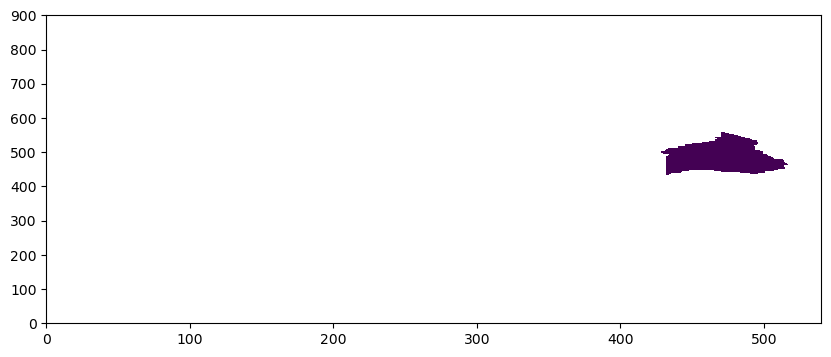

In [6]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

## Get the timesteps

In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# first set of dates
# times["2003"] = np.arange(1,13,1)
# times["2004"] = np.arange(1,13,1)
# times["2005"] = np.arange(1,13,1)
# times["2006"] = np.arange(1,13,1)
# times["2007"] = np.arange(1,13,1)

# second set of dates
times["2013"] = np.arange(1,13,1)
# times["2014"] = np.arange(1,13,1)
# times["2015"] = np.arange(1,13,1)
# times["2016"] = np.arange(1,13,1)
# times["2017"] = np.arange(1,13,1)
m = 2



# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [8]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [9]:
# ocean and ice
AB_gT=0
AB_gS=0

In [10]:
ffac = 1e-6

In [11]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) #* ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)


# we want an average of the theta and salt, so we can read from the average files and then do averaging from these

In [12]:
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))
DRF3d.shape

(50, 1350, 270)

In [13]:
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


THETADR = np.zeros((len(tsstr)-1,nz,ny,nx))
SALTDR = np.zeros((len(tsstr)-1,nz,ny,nx))
binned_theta = np.zeros((len(tsstr)-1,nz,ny,nx))
binned_salt = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpTHETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    tmpSALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
    tmpTHETA = tmpTHETA.reshape(nz,ny,nx)
    tmpSALT = tmpSALT.reshape(nz,ny,nx)

    # set in larger array
    THETADR[t] = tmpTHETA * DRF3d
    SALTDR[t] = tmpSALT * DRF3d

# do the weighting by DRF, then do averaging in depth

In [14]:
mymsk3 = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

In [15]:
THETA = np.nanmean(THETADR,axis=0) / DRF3d  # degC 
SALT = np.nanmean(SALTDR,axis=0) / DRF3d    # PSU

In [16]:
# we can also average volume for the year
vol_tmean = np.nanmean(vol,axis=0)          # m^3

In [17]:
m = 8

In [18]:
# THETA = THETADR[m] /DRF3d
# SALT = SALTDR[m] / DRF3d
# vol_tmean = vol[m]

In [19]:
del THETADR, SALTDR,vol

In [20]:
# create the bins of TS data
# try new T bins where different sizes
refined_section = np.linspace(-3,8,63)
coarse_section = np.linspace(8,31,51,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 31, 30, endpoint=False)
refined_section = np.linspace(31, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [21]:
# now do the binning for the vol_tmean based on the THETA and SALT
binned_theta = bin_array(THETA,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan
binned_theta = binned_theta * mymsk3

# do the salt now
binned_salt = bin_array(SALT,binsSLT_edges)
binned_salt = binned_salt.astype(float)
binned_salt[binned_salt == nS] = np.nan
binned_salt = binned_salt * mymsk3

In [22]:
tsstr[:1]

array(['0000578592'], dtype='<U32')

In [23]:
idxs = np.where(mymsk == 1)
npoints = len(idxs[0])
npoints

6648

In [24]:
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# uncomment these lines to look at just the surface terms in the TS diagram
# vol_tmean = vol_tmean.copy()
# vol_tmean[1:] = np.nan

# if we want to do just the surface of the basin:
mesh = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol_tmean.reshape(1,nz,ny,nx),idxs,dT,dS)

In [25]:
# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

In [26]:
del mesh

In [27]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [28]:
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


In [29]:
# write vol_mesh to a file to save it so we can plot both at once

In [30]:
# vol_mesh_2003_2007 = vol_mesh.copy()
# datetimes_2003_2007 = datetimes.copy()

# plot just the volume distribution

In [31]:
# # for plotting just the volume without arrows


# fig = plt.figure(figsize=(12,5))
# plt.subplots_adjust(hspace=0.8)  # bigger hspace -- more vertical space


# ax1 = plt.subplot(121)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh_2003_2007), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes_2003_2007[0].strftime("%Y") + "-" + datetimes_2003_2007[-1].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,9)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # CHECK WITH AN: THIS DOES NOT LOOK CORRECT FOR T_F
# # fline = ax1.plot(si,Freez_temp,'-',color='silver',linestyle="dashed",label="$T_{f}$",alpha=0.9,zorder=9,linewidth=3)

# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")


# # add another subplot for the second set of times
# ax1 = plt.subplot(122)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,9)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # plt.savefig(path + "annual_comparison_ONLYBARENTSsurface.png",dpi=300)

# load the J terms from another file and plot them on the sea

In [32]:
# what if we do just the surface distribution of these

In [33]:
# create the example vectors in a mesh for=
# dsT = xr.open_dataset("J_heat_2003_v2.nc")
dsT = xr.open_dataset("J_heat_2013.nc")
mean_JtendTfull = dsT['JtendTfull'].mean(dim='time')  # for averaging for a given year
# mean_JtendTfull = dsT['JtendTfull'][m]
meshTtend = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JtendTfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

In [34]:
# dsS = xr.open_dataset("J_salt_2003_v2.nc")
dsS = xr.open_dataset("J_salt_2013.nc")
mean_JtendSfull = dsS['JtendSfull'].mean(dim='time')
# mean_JtendSfull = dsS['JtendSfull'][m]
meshStend = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JtendSfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

In [35]:
meshTtend = np.nansum(meshTtend[0],axis=2)
meshStend = np.nansum(meshStend[0],axis=2)

In [36]:
# do for the other terms just to see
# create the example vectors in a mesh for

mean_JADVTfull = dsT['JADVTfull'].mean(dim='time')
# mean_JADVTfull = dsT['JADVTfull'][m]
meshTADV = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JADVTfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

mean_JADVSfull = dsS['JADVSfull'].mean(dim='time')
# mean_JADVSfull = dsS['JADVSfull'][m]
meshSADV = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JADVSfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

meshTADV = np.nansum(meshTADV[0],axis=2)
meshSADV = np.nansum(meshSADV[0],axis=2)

In [37]:
# do for the other terms just to see
# create the example vectors in a mesh for=
mean_JDFTfull = dsT['JDFTfull'].mean(dim='time')
# mean_JDFTfull = dsT['JDFTfull'][m]
meshTDF = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JDFTfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

mean_JDFSfull = dsS['JDFSfull'].mean(dim='time')
# mean_JDFSfull = dsS['JDFSfull'][m]
meshSDF = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JDFSfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

meshTDF = np.nansum(meshTDF[0],axis=2)
meshSDF = np.nansum(meshSDF[0],axis=2)

In [38]:
# do for the other terms just to see
# create the example vectors in a mesh for=
mean_JKPPTfull = dsT['JKPPTfull'].mean(dim='time')
# mean_JKPPTfull = dsT['JKPPTfull'][m]
meshTKPP = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JKPPTfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

mean_JKPPSfull = dsS['JKPPSfull'].mean(dim='time')
# mean_JKPPSfull = dsS['JKPPSfull'][m]
meshSKPP = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JKPPSfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

meshTKPP = np.nansum(meshTKPP[0],axis=2)
meshSKPP = np.nansum(meshSKPP[0],axis=2)

In [39]:
# do for the other terms just to see
# create the example vectors in a mesh for=
mean_JsurfTfull = dsT['JsurfTfull'].mean(dim='time')
# mean_JsurfTfull = dsT['JsurfTfull'][m]
meshTsurf = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JsurfTfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

mean_JsurfSfull = dsS['JsurfSfull'].mean(dim='time')
# mean_JsurfSfull = dsS['JsurfSfull'][m]
meshSsurf = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_JsurfSfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

meshTsurf = np.nansum(meshTsurf[0],axis=2)
meshSsurf = np.nansum(meshSsurf[0],axis=2)

In [40]:
# # do for the other terms just to see
# # create the example vectors in a mesh for=
# mean_Tbudgetfull = dsT['budgetfull'].mean(dim='time')
# meshTbudget = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_Tbudgetfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

# mean_Sbudgetfull = dsS['budgetfull'].mean(dim='time')
# meshSbudget = create_TS_mesh(tsstr[:1],nS,nT,npoints,binned_salt.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),(mean_Sbudgetfull.values*mymsk3).reshape(1,nz,ny,nx),idxs,dT,dS)

# meshTbudget = np.nansum(meshTbudget[0],axis=2)
# meshSbudget = np.nansum(meshSbudget[0],axis=2)

In [41]:
# # let's look two sets of months to verify this

# # what if we just plot a volume distribution for the year 2003
# space = 2
# U = 5
# U= 50
# scale=1e2
# scale = 1e3

# fig = plt.figure(figsize=(12,9))

# # total tendency
# ax1 = plt.subplot(231)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# # ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,10)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # add the quivers - really hope there's nothing wrong here
# # U1,V1 = meshStend/dT[:,:,0]/dS[:,:,0]*1e-6,meshTtend/dT[:,:,0]/dS[:,:,0]*1e-6
# U1,V1 = meshStend,meshTtend
# q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
# ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv")
# ax1.set_title("Total Tend " + datetimes[m].strftime("%m %Y"))


# # advective tendency
# ax1 = plt.subplot(232)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# # ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,10)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # add the quivers - really hope there's nothing wrong here
# # U1,V1 = meshSADV/dT[:,:,0]/dS[:,:,0]*1e-6,meshTADV/dT[:,:,0]/dS[:,:,0]*1e-6
# U1,V1 = meshSADV,meshTADV
# q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
# ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
# ax1.set_title("Adv Tend " + datetimes[m].strftime("%m %Y"))


# # diffusive tendency
# ax1 = plt.subplot(233)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# # ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,10)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # add the quivers - really hope there's nothing wrong here
# # U1,V1 = meshSDF/dT[:,:,0]/dS[:,:,0]*1e-6,meshTDF/dT[:,:,0]/dS[:,:,0]*1e-6
# U1,V1 = meshSDF,meshTDF
# q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
# ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
# ax1.set_title("DF Tend " + datetimes[m].strftime("%m %Y"))


# # KPP tendency
# ax1 = plt.subplot(234)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# # ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,10)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # add the quivers - really hope there's nothing wrong here
# # U1,V1 = meshSKPP/dT[:,:,0]/dS[:,:,0]*1e-6,meshTKPP/dT[:,:,0]/dS[:,:,0]*1e-6
# U1,V1 = meshSKPP,meshTKPP
# q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

# ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
# ax1.set_title("KPP Tend " + datetimes[m].strftime("%m %Y"))



# # surface tendency
# ax1 = plt.subplot(235)
# ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
# plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# # ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
# ax1.set_xlim(32,36)
# ax1.set_ylim(-2,10)
# ax1.set_xlabel("Salinity (PSU)")
# ax1.set_ylabel("Temperature (deg C)")
# # add the contours
# cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
# cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# # add the quivers - really hope there's nothing wrong here
# # U1,V1 = meshSsurf/dT[:,:,0]/dS[:,:,0]*1e-6,meshTsurf/dT[:,:,0]/dS[:,:,0]*1e-6
# U1,V1 = meshSsurf,meshTsurf
# q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

# ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
# ax1.set_title("Surface Tend " + datetimes[m].strftime("%m %Y"))


# plt.savefig(path + "2013_tendency_sept.png",dpi=300)

Text(0.5, 1.0, 'Surface Tend Average 2013')

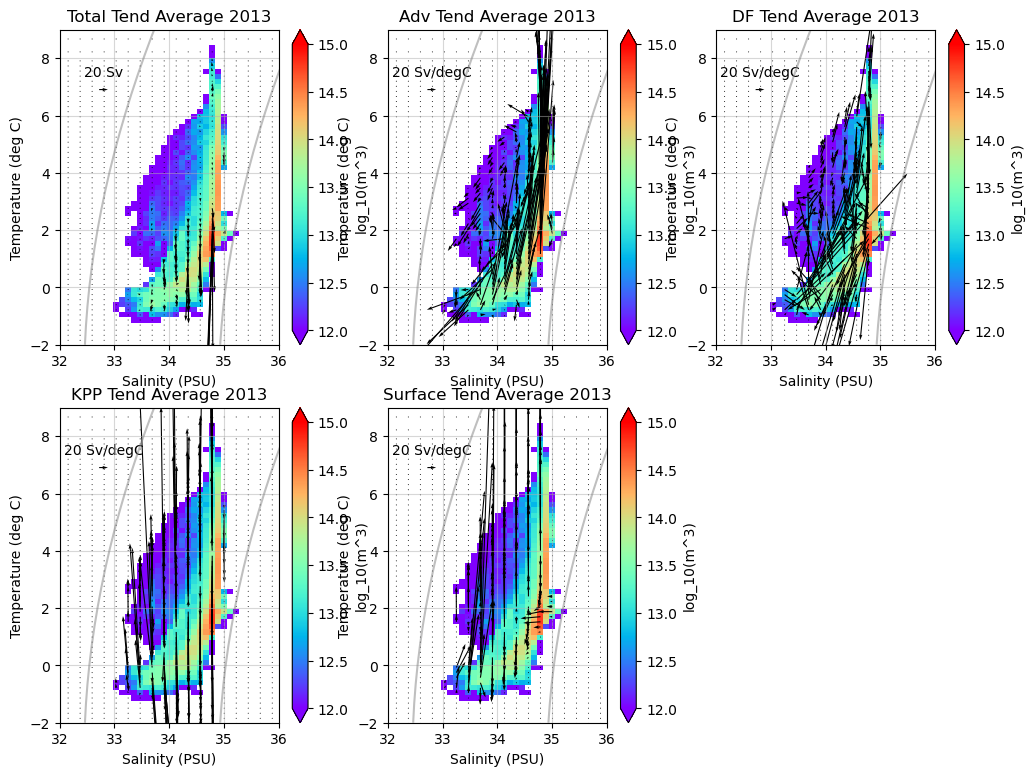

In [42]:
# what if we just plot a volume distribution for the year 2003
space = 2
U = 5
U= 20
scale=1e2
scale = 5e2

fig = plt.figure(figsize=(12,9))

# total tendency
ax1 = plt.subplot(231)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshStend/dT[:,:,0]/dS[:,:,0]*1e-6,meshTtend/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshStend,meshTtend
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv")
ax1.set_title("Total Tend Average " + datetimes[0].strftime("%Y"))


# advective tendency
ax1 = plt.subplot(232)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSADV/dT[:,:,0]/dS[:,:,0]*1e-6,meshTADV/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSADV,meshTADV
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("Adv Tend Average " + datetimes[0].strftime("%Y"))


# diffusive tendency
ax1 = plt.subplot(233)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSDF/dT[:,:,0]/dS[:,:,0]*1e-6,meshTDF/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSDF,meshTDF
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("DF Tend Average " + datetimes[0].strftime("%Y"))


# KPP tendency
ax1 = plt.subplot(234)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSKPP/dT[:,:,0]/dS[:,:,0]*1e-6,meshTKPP/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSKPP,meshTKPP
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("KPP Tend Average " + datetimes[0].strftime("%Y"))



# surface tendency
ax1 = plt.subplot(235)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSsurf/dT[:,:,0]/dS[:,:,0]*1e-6,meshTsurf/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSsurf,meshTsurf
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("Surface Tend Average " + datetimes[0].strftime("%Y"))


# plt.savefig(path + "2013_tendency_comparison_v3.png",dpi=300)

# try to look at a convergence of terms

In [53]:
dS = np.gradient(Sbin, axis=0)[1:,1:]  # Gradient in salinity direction
dT = np.gradient(Tbin, axis=1)[1:,1:]

dU1_dS = np.gradient(meshStend, axis=1) / dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTtend, axis=0) / dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT

Text(0.5, 1.0, 'Total Tend Average 2013')

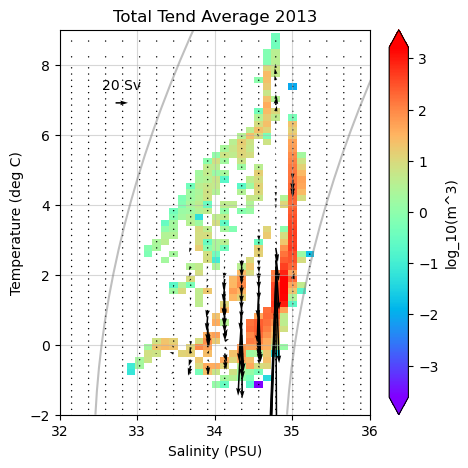

In [57]:
# what if we just plot a volume distribution for the year 2003
space = 2
U = 5
U= 20
scale = 5e2

fig = plt.figure(figsize=(5,5))

# total tendency
ax1 = plt.subplot(111)
ax1.grid(alpha=0.5,zorder=0)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow")#, vmin=12,zorder=1)#,vmax=15)
plt.colorbar(cb1, label="log_10(m^3)",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshStend/dT[:,:,0]/dS[:,:,0]*1e-6,meshTtend/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshStend,meshTtend
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv")
ax1.set_title("Total Tend Average " + datetimes[0].strftime("%Y"))

Text(0.5, 1.0, 'Surface Tend Average 2013')

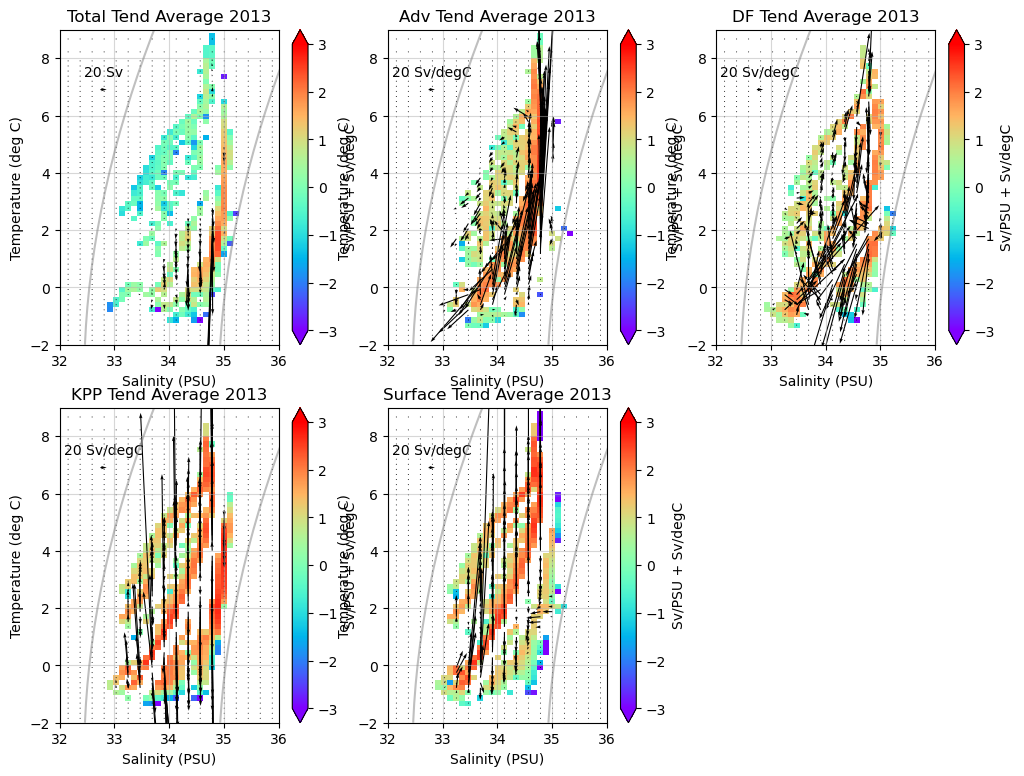

In [62]:
# what if we just plot a volume distribution for the year 2003
space = 2
U = 5
U= 20
scale=1e2
scale = 7e2

fig = plt.figure(figsize=(12,9))

# total tendency
ax1 = plt.subplot(231)
ax1.grid(alpha=0.5,zorder=0)

dU1_dS = np.gradient(meshStend, axis=1) #/ dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTtend, axis=0) #/ dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT

cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow", vmin=-3,zorder=1,vmax=3)
plt.colorbar(cb1, label="Sv/PSU + Sv/degC",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshStend/dT[:,:,0]/dS[:,:,0]*1e-6,meshTtend/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshStend,meshTtend
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv")
ax1.set_title("Total Tend Average " + datetimes[0].strftime("%Y"))


# advective tendency
ax1 = plt.subplot(232)
ax1.grid(alpha=0.5,zorder=0)

dU1_dS = np.gradient(meshSADV, axis=1) #/ dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTADV, axis=0) #/ dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT

cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow", vmin=-3,zorder=1,vmax=3)
plt.colorbar(cb1, label="Sv/PSU + Sv/degC",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSADV/dT[:,:,0]/dS[:,:,0]*1e-6,meshTADV/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSADV,meshTADV
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("Adv Tend Average " + datetimes[0].strftime("%Y"))


# diffusive tendency
ax1 = plt.subplot(233)
ax1.grid(alpha=0.5,zorder=0)
dU1_dS = np.gradient(meshSDF, axis=1) #/ dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTDF, axis=0) #/ dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT

cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow", vmin=-3,zorder=1,vmax=3)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
plt.colorbar(cb1, label="Sv/PSU + Sv/degC",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSDF/dT[:,:,0]/dS[:,:,0]*1e-6,meshTDF/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSDF,meshTDF
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)
ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("DF Tend Average " + datetimes[0].strftime("%Y"))


# KPP tendency
ax1 = plt.subplot(234)
ax1.grid(alpha=0.5,zorder=0)
# cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap="rainbow", vmin=12,zorder=1,vmax=15)
dU1_dS = np.gradient(meshSKPP, axis=1) #/ dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTKPP, axis=0) #/ dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT

cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow", vmin=-3,zorder=1,vmax=3)
plt.colorbar(cb1, label="Sv/PSU + Sv/degC",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSKPP/dT[:,:,0]/dS[:,:,0]*1e-6,meshTKPP/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSKPP,meshTKPP
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("KPP Tend Average " + datetimes[0].strftime("%Y"))



# surface tendency
ax1 = plt.subplot(235)
ax1.grid(alpha=0.5,zorder=0)

dU1_dS = np.gradient(meshSsurf, axis=1) #/ dS  # Change in U1 w.r.t salinity
dV1_dT = np.gradient(meshTsurf, axis=0) #/ dT  # Change in V1 w.r.t temperature

divergence = dU1_dS + dV1_dT
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(divergence), cmap="rainbow", vmin=-3,zorder=1,vmax=3)
plt.colorbar(cb1, label="Sv/PSU + Sv/degC",extend="both")
# ax1.set_title("ASTE BarentsS surface volume averaged " + datetimes[0].strftime("%Y"))
ax1.set_xlim(32,36)
ax1.set_ylim(-2,9)
ax1.set_xlabel("Salinity (PSU)")
ax1.set_ylabel("Temperature (deg C)")
# add the contours
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2,alpha=0.5,levels=np.arange(16,32,2))
cl=ax1.clabel(cs,fontsize=10,inline=False,fmt="%.f")

# add the quivers - really hope there's nothing wrong here
# U1,V1 = meshSsurf/dT[:,:,0]/dS[:,:,0]*1e-6,meshTsurf/dT[:,:,0]/dS[:,:,0]*1e-6
U1,V1 = meshSsurf,meshTsurf
q1 = ax1.quiver(Sbincent[::space], Tbincent[::space], U1[::space], V1[::space], width=0.005,scale=scale)

ax1.quiverkey(q1,X=0.2,Y=0.81,U = U,label=str(U) + " Sv/degC")
ax1.set_title("Surface Tend Average " + datetimes[0].strftime("%Y"))


# plt.savefig(path + "2013_tendency_comparison_v3.png",dpi=300)